# <span style="color:blue">EVAC Workshop 5: Basic neural evolution</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the neural network lectures

## <span style="color:#0073e6">Topics</span>

- Basic neural evolution

## <span style="color:#0073e6">Learning objectives</span>

- To understand how to evolve weights in a static topology neural network


# <span style="color:blue">Exercise: evolving weights of simple MLP</span>

In this practical you will evolve weights of a simple MLP with a static structure.

# <span style="color:blue">Task: evolving weights of simple MLP</span>

The problem that you will address is the 'exclusive OR' problem (XOR). We are using this problem, because it is simple, yet it is known that a hidden layer is needed in a MPL to solve this problem because it is not linearly separable. The XOR problem takes in two binary inputs and outputs a 1 if either are a one, but not both:

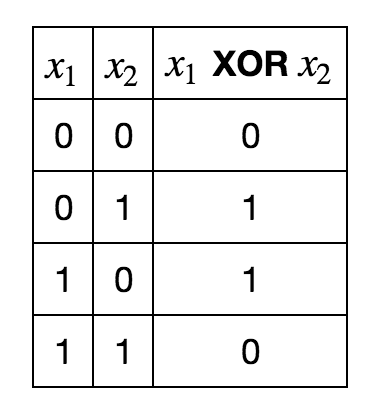



# <span style="color:blue">Defining a simple neural network</span>

There are packages out there dedicated to producing neural networks, such as Tensorflow and Pytorch. However, for simplicity we will implement our own basic MLP, fully-connected and hard-coded with just one hidden layer. This is implemented the same as in the walkthrough. **However, for speed, this implementation has only one hidden layer.**

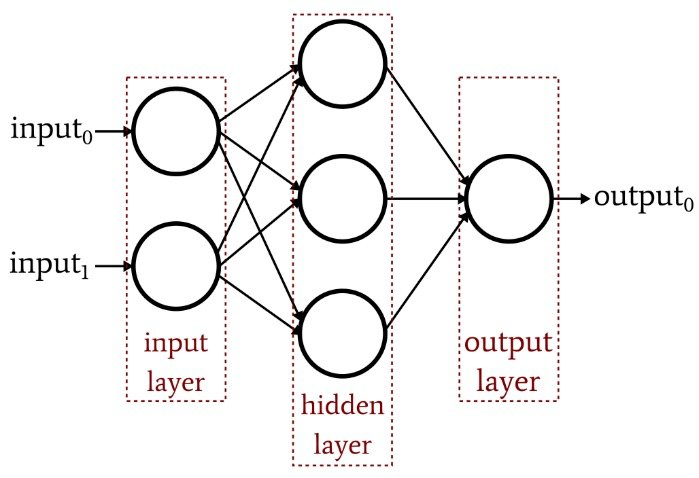


We start by defining a class for our network:

In [369]:
import numpy as np
import math

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

First we define the feedforward function of our network. To do this, we simply take the dot product of the input array and the weights from that input to the next layer of nodes. We then run those weighted sums through the ReLU function in the hidden layer, and the sigmoid in the last layer. This makes it similar to a non-linear regression problem.

In [370]:
class MLP(MLP):
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)                 # Add bias input
        h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
        output = np.dot(self.wo, h1)                 # feed to output layer
        output = [self.sigmoid(x) for x in output]   # Activate output layer
        return output

Next we define functions that allow the genetic algorithm to get and set the weights as a simple one-dimensional list. This means we can then just work with the built-in operators without having to worry about defining our own to work with multidimensional arrays.

In [371]:
class MLP(MLP):

    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

We will create a multi-layer perceptron with 2 inputs, 3 hidden nodes (in a single hidden layer), and 1 output.

In [372]:
myNet = MLP(2,3,1)
myNet.setWeightsLinear([1,1,1,1,1,1,1,1,1,1,1,0.5])

In [373]:
a = myNet.getWeightsLinear()
print(a)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0, 1.0, 0.5]


It takes in a list of size 2, and gives a list as output, with each element in the list being the output nodes (here we only have 1).

In [374]:
inputs = [0,1]

In [375]:
outcome = myNet.feedForward(inputs)

The outcome will be between 0 and 1, due to the sigmoid function. To make this binary we can add a step function.

In [376]:
print(outcome)

[0.9933071490757153]


In [377]:
int(outcome[0] > 0.5)

1

# <span style="color:blue">Exercise: Implement your Genetic Algorithm Here</span>

In [378]:
from turtle import Turtle, Screen, Shape
import random
import math
from datetime import datetime
import numpy as np
from deap import base, creator, tools, algorithms

In [379]:
numInputNodes = 2
numHiddenNodes1 = 3
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)
print(IND_SIZE)

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)

12


In [380]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)


In [381]:
def xorevaluate(indiv, myNet):
  myNet.setWeightsLinear(indiv)
  inputs = [[0,0],[0,1],[1,0],[1,1]]
  outputs = [0,1,1,0]
  error = 0
  for i in range(4):
    outcome = myNet.feedForward(inputs[i])

    if (int(outcome[0] > 0.5) != outputs[i]):
      error += 1
    
  return (error,)

## Test the evaluation function
ind = toolbox.individual()
print(ind)
print(xorevaluate(ind, myNet))



[0.8320455128773123, 0.6204395876771942, 0.48710350757345533, -0.9170558876724242, 0.12128778136584062, -0.11390512356605154, -0.15056322970195812, 0.33734600068019827, -0.7589073072100878, 0.28404099462365084, 0.5986268811924842, 0.39311763333590743]
(2,)


In [382]:
toolbox.register("evaluate", xorevaluate)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.1)

In [383]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [384]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [385]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [386]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [387]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

-- Generation 82 --
-- Generation 83 --
-- Generation 84 --
-- Generation 85 --
-- Generation 86 --
-- Generation 87 --
-- Generation 88 --
-- Generation 89 --
-- Generation 90 --
-- Generation 91 --
-- Generation 92 --
-- Generation 93 --
-- Generation 94 --
-- Generation 95 --
-- Generation 96 --
-- Generation 97 --
-- Generation 98 --
-- Generation 99 --
-- Generation 100 --
-- Generation 101 --
-- Generation 102 --
-- Generation 103 --
-- Generation 104 --
-- Generation 105 --
-- Generation 106 --
-- Generation 107 --
-- Generation 108 --
-- Generation 109 --
-- Generation 110 --
-- Generation 111 --
-- Generation 112 --
-- Generation 113 --
-- Generation 114 --
-- Generation 115 --
-- Generation 116 --
-- Generation 117 --
-- Generation 118 --
-- Generation 119 --
-- Generation 120 --
-- Generation 121 --
-- Generation 122 --
-- Generation 123 --
-- Generation 124 --
-- Generation 125 --
-- Generation 126 --
-- Generation 127 --
-- Generation 128 --
-- Generation 129 --
-- Generat

In [388]:
logbook.header = "gen", "avg", "evals", "std", "min", "max"
print(logbook)

gen	avg 	evals	std     	min	max
0  	1.83	     	0.510979	0  	3  
1  	1.51	     	0.608194	0  	2  
2  	1.31	     	0.611474	0  	2  
3  	1.05	     	0.572276	0  	2  
4  	0.94	     	0.562494	0  	2  
5  	0.78	     	0.769155	0  	3  
6  	0.62	     	0.703989	0  	3  
7  	0.45	     	0.638357	0  	3  
8  	0.41	     	0.664756	0  	3  
9  	0.4 	     	0.648074	0  	2  
10 	0.34	     	0.586856	0  	2  
11 	0.35	     	0.606218	0  	2  
12 	0.3 	     	0.519615	0  	2  
13 	0.35	     	0.589491	0  	2  
14 	0.35	     	0.53619 	0  	2  
15 	0.42	     	0.650846	0  	2  
16 	0.29	     	0.534696	0  	2  
17 	0.44	     	0.60531 	0  	2  
18 	0.35	     	0.517204	0  	2  
19 	0.17	     	0.401373	0  	2  
20 	0.28	     	0.511468	0  	2  
21 	0.39	     	0.676683	0  	3  
22 	0.36	     	0.591946	0  	2  
23 	0.24	     	0.449889	0  	2  
24 	0.38	     	0.612862	0  	3  
25 	0.37	     	0.594222	0  	2  
26 	0.35	     	0.53619 	0  	2  
27 	0.26	     	0.502394	0  	2  
28 	0.26	     	0.54074 	0  	2  
29 	0.27	     	0.50705 	0  	2  
30 	0.29

In [390]:
indiv1 = tools.selBest(pop, 1)[0]
toolbox.evaluate(indiv1, myNet)

inputs = [[0,0],[0,1],[1,0],[1,1]]
for i in range(4):
  myNet.setWeightsLinear(indiv1)
  outcome = myNet.feedForward(inputs[i])
  print(inputs[i], outcome, int(outcome[0] > 0.5))

print(toolbox.evaluate(indiv1, myNet))

[0, 0] [0.5] 0
[0, 1] [0.7764045005694192] 1
[1, 0] [0.9014566150346126] 1
[1, 1] [0.13753864505323946] 0
(0,)
